### 1. Importamos librerias

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

### 2. Leemos los ficheros

In [2]:
cobros = pd.read_csv("data/cobros_gestor.csv")
tasa = pd.read_csv("data/tasa_horaria.csv")
dimensionamiento = pd.read_csv("data/Dimensionamiento.csv")
vacaciones = pd.read_csv("data/vacaciones.csv")
segmento_maestra = pd.read_csv("data/segmento_mestra.csv")
absentismo = pd.read_csv("data/absentismo.csv")
calidad = pd.read_csv("data/calidad.csv")
eficacia = pd.read_csv("data/eficacias.csv")
normalizacion = pd.read_csv("data/normalizacion.csv")
santander = pd.read_csv("data/santandercf.csv")

**Muy importante: Para poder hacer el merge de las tablas necesitamos que las columnas estén igual nombradas**

### 3. Tabla RRHH

Esta tabla contiene la información de cada usuario de acuerdo a sus horas trabajadas, absentismo y calidad.
Para estos calculos se ha tenido en cuenta el dimensionamiento, absentismo, vacaciones y calidad.

In [3]:
#Unimos la tabla dimensionamiento con la tabla vacaciones por usuario
rrhh = dimensionamiento.merge(vacaciones, on='usuario', how="left")
#Unimos la tabla anterior con la tabla absentismo por usuario
rrhh = rrhh.merge(absentismo, on='usuario', how="left")
#Creamos una columna condicional para tener el absentismo en horas
# Si la columna tipo es igual a hora entonces la nueva columna (horas_absentismo) será el total_solicitado
# si contiene otra cosa que no sea hora devolverá el valor de total_solicitado*horas_dia
conditions = [(rrhh.tipo == "hora")]
choicelist = [rrhh.total_solicitado]
rrhh['horas_absentismo'] = np.select(conditions, choicelist, default=rrhh.total_solicitado*rrhh.horas_dia)
#Creamos la columna horas_no_efectivas es la suma de horas_no_efectivas y las vacaciones en horas
rrhh['horas_no_efectivas'] = rrhh.horas_no_efectivas + rrhh.total_dias_solicitado*rrhh.horas_dia
#Agrupamos para tener el total de horas_no_efectivas y horas_absentismo por usuario
rrhh = rrhh.groupby(['usuario', 'turno', 'horas_dia', 'horas_mes']).sum()[["horas_no_efectivas", 'horas_absentismo']].reset_index()
#Creamos una nueva columna
rrhh['horas_TH_trabajadas'] = rrhh.horas_mes - rrhh.horas_no_efectivas
#Creamos una nueva columna
rrhh['horas_trabajadas'] = rrhh.horas_mes - rrhh.horas_no_efectivas - rrhh.horas_absentismo
#Creamos una nueva columna
rrhh['presentismo'] = rrhh.horas_trabajadas / rrhh.horas_TH_trabajadas
#Creamos una nueva columna
rrhh['factor_corrector'] = rrhh.horas_TH_trabajadas / rrhh.horas_mes
#Unimos la tabla rrhh con la tabla calidad por usuario
rrhh = rrhh.merge(calidad, on='usuario', how="left")
rrhh

,usuario,turno,horas_dia,horas_mes,horas_no_efectivas,horas_absentismo,horas_TH_trabajadas,horas_trabajadas,presentismo,factor_corrector,pnt_calidad
0,alias,Tarde,7.5,150,0.0,0.0,150.0,150.0,1.000000,1.000000,0.97
1,bmartin,Mañana,7.0,140,0.0,0.0,140.0,140.0,1.000000,1.000000,0.95
2,eloina,Mañana,7.5,150,0.0,0.0,150.0,150.0,1.000000,1.000000,1.00
3,emolinero,Mañana,7.0,140,24.0,11.0,116.0,105.0,0.905172,0.828571,0.95
4,jramon,Tarde,7.5,150,32.0,10.5,118.0,107.5,0.911017,0.786667,1.00
5,sgarcia,Mañana,7.0,140,35.0,0.0,105.0,105.0,1.000000,0.750000,1.00


### 4. Cobros

Esta tabla tiene la informacion de los cobros y el numero de cobros que ha realizado cada usuario

In [4]:
#Unimos la tabla cobros con segmento_maestra por segmento
cobros_totales = cobros.merge(segmento_maestra, on='segmento', how="left")
#Creamos una nueva columna
cobros_totales['usuario_segmento'] = cobros_totales.usuario+cobros_totales.segmento_maestra
#Agrupamos para saber el total de cobros y el numero de cobros que ha realizado cada usuario en su segmento
cobros_totales = cobros_totales.groupby(['usuario', 'segmento_maestra', 'usuario_segmento'])['cobros_eur'].agg(
    ['sum','count']).reset_index()
cobros_totales

,usuario,segmento_maestra,usuario_segmento,sum,count
0,emolinero,BI,emolineroBI,280,3
1,emolinero,FECI,emolineroFECI,120,2
2,emolinero,ING,emolineroING,310,2
3,jramon,BI,jramonBI,800,2
4,jramon,FECI,jramonFECI,420,2
5,jramon,ING,jramonING,1300,4
6,jramon,SCF,jramonSCF,370,4
7,sgarcia,BI,sgarciaBI,780,4
8,sgarcia,FECI,sgarciaFECI,580,3
9,sgarcia,ING,sgarciaING,450,3


Tenemos una información que no la podemos de la misma base de datos, por lo que tendremos otro fichero el cual hay que unirlo al de cobros.

In [5]:
#Agrupamos para saber el total de cobros y el numero de cobros que ha realizado cada usuario en su segmento
santander_gb = santander.groupby(['usuario', 'segmento_maestra', 'usuario_segmento'])['cobros_eur'].agg(
    ['sum','count']).reset_index()
santander_gb

,usuario,segmento_maestra,usuario_segmento,sum,count
0,bmartin,SANTANDERCF,bmartinSANTANDERCF,30,1
1,eloina,SANTANDERCF,eloinaSANTANDERCF,600,1


In [6]:
#Unimos la tabla cobros con tabla santander_gb
cobros_totales = cobros_totales.merge(santander_gb, how='outer')
cobros_totales

,usuario,segmento_maestra,usuario_segmento,sum,count
0,emolinero,BI,emolineroBI,280,3
1,emolinero,FECI,emolineroFECI,120,2
2,emolinero,ING,emolineroING,310,2
3,jramon,BI,jramonBI,800,2
4,jramon,FECI,jramonFECI,420,2
5,jramon,ING,jramonING,1300,4
6,jramon,SCF,jramonSCF,370,4
7,sgarcia,BI,sgarciaBI,780,4
8,sgarcia,FECI,sgarciaFECI,580,3
9,sgarcia,ING,sgarciaING,450,3


### 5. Tasa

En esta tabla está el tiempo que cada agente trabaja por segmentos

In [7]:
#Unimos la tabla tasa con la tabla segmento_maestra
tasa_corr = tasa.merge(segmento_maestra, on='segmento', how="left")
#Creamos una columna nueva
tasa_corr['usuario_segmento'] = tasa_corr.usuario+tasa_corr.segmento_maestra
#Agrupamos para tener el total de horas por segmento de cada usuario
tasa_corr = tasa_corr.groupby(['usuario', 'segmento_maestra', 'usuario_segmento']).sum().reset_index()
#Como los datos de santandercf no podemos obtenerlos, tenemos que unirlo para tener todos los datos agrupados en una tabla
#Unimos la tabla tasa con la tabla santander
tasa_corr = tasa_corr.merge(santander[["usuario", "segmento_maestra", "usuario_segmento", "tasa_horaria"]], how='outer')
tasa_corr

/home/dsc/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:1204: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


,usuario,segmento_maestra,usuario_segmento,tasa_horaria
0,alias,PREVENTIVO,aliasPREVENTIVO,1.00
1,emolinero,BI,emolineroBI,0.60
2,emolinero,FECI,emolineroFECI,0.05
3,emolinero,ING,emolineroING,0.30
4,emolinero,SCF,emolineroSCF,0.05
5,jramon,BI,jramonBI,0.65
6,jramon,FECI,jramonFECI,0.10
7,jramon,ING,jramonING,0.20
8,jramon,SCF,jramonSCF,0.05
9,sgarcia,BI,sgarciaBI,0.70


### 6.  Calculo de notas

Calculamos para cada usuario una nota en su segmento

In [8]:
notas = tasa_corr.merge(cobros_totales, how="left")
notas = notas.merge(eficacia, on=["usuario","segmento_maestra", "usuario_segmento", "tasa_horaria"], how="outer")
notas = notas.merge(rrhh[['usuario', 'horas_trabajadas', 'factor_corrector']], on='usuario', how='left')
notas['h_trab_seg'] = notas.tasa_horaria*notas.horas_trabajadas
notas['cobros_hora'] = notas['sum']/notas.h_trab_seg
notas['eficacia_hora'] = notas['eficacias']/notas.h_trab_seg
notas = notas.fillna(0)
notas['suma_notas'] = notas.cobros_hora + notas.eficacia_hora
notas = notas.merge(normalizacion, on="segmento_maestra", how='left')
notas

/home/dsc/anaconda3/lib/python3.8/site-packages/pandas/core/reshape/merge.py:1204: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


,usuario,segmento_maestra,usuario_segmento,tasa_horaria,sum,count,eficacias,horas_trabajadas,factor_corrector,h_trab_seg,cobros_hora,eficacia_hora,suma_notas,max,min
0,alias,PREVENTIVO,aliasPREVENTIVO,1.00,0.0,0.0,30.0,150.0,1.000000,150.000,0.000000,0.2,0.200000,100,20
1,emolinero,BI,emolineroBI,0.60,280.0,3.0,0.0,105.0,0.828571,63.000,4.444444,0.0,4.444444,80,5
2,emolinero,FECI,emolineroFECI,0.05,120.0,2.0,0.0,105.0,0.828571,5.250,22.857143,0.0,22.857143,90,10
3,emolinero,ING,emolineroING,0.30,310.0,2.0,0.0,105.0,0.828571,31.500,9.841270,0.0,9.841270,90,10
4,emolinero,SCF,emolineroSCF,0.05,0.0,0.0,0.0,105.0,0.828571,5.250,0.000000,0.0,0.000000,90,10
5,jramon,BI,jramonBI,0.65,800.0,2.0,0.0,107.5,0.786667,69.875,11.449016,0.0,11.449016,80,5
6,jramon,FECI,jramonFECI,0.10,420.0,2.0,0.0,107.5,0.786667,10.750,39.069767,0.0,39.069767,90,10
7,jramon,ING,jramonING,0.20,1300.0,4.0,0.0,107.5,0.786667,21.500,60.465116,0.0,60.465116,90,10
8,jramon,SCF,jramonSCF,0.05,370.0,4.0,0.0,107.5,0.786667,5.375,68.837209,0.0,68.837209,90,10
9,sgarcia,BI,sgarciaBI,0.70,780.0,4.0,0.0,105.0,0.750000,73.500,10.612245,0.0,10.612245,80,5


In [9]:
df = notas.copy()
df = df.groupby(["segmento_maestra"])["suma_notas"].agg(["max", "min"]).reset_index()
df['range_seg']=df['max']-df['min']
df = df.rename(columns={'max':'max_seg',
                   'min':'min_seg'})
df

,segmento_maestra,max_seg,min_seg,range_seg
0,BI,11.449016,4.444444,7.004572
1,FECI,110.476190,22.857143,87.619048
2,ING,60.465116,9.841270,50.623846
3,PREVENTIVO,0.200000,0.200000,0.000000
4,SANTANDERCF,4.000000,0.214286,3.785714
5,SCF,89.523810,0.000000,89.523810


In [10]:
notas = notas.merge(df, on='segmento_maestra', how='left')
conditions_range = [(notas.range_seg == 0)]
notas['notas_f_corr']=np.select(conditions_range,[notas['max']],default=(notas.suma_notas-notas.min_seg)*(notas['max']-notas['min'])/notas.range_seg+notas['min'])
notas

,usuario,segmento_maestra,usuario_segmento,tasa_horaria,sum,count,eficacias,horas_trabajadas,factor_corrector,h_trab_seg,cobros_hora,eficacia_hora,suma_notas,max,min,max_seg,min_seg,range_seg,notas_f_corr
0,alias,PREVENTIVO,aliasPREVENTIVO,1.00,0.0,0.0,30.0,150.0,1.000000,150.000,0.000000,0.2,0.200000,100,20,0.200000,0.200000,0.000000,100.000000
1,emolinero,BI,emolineroBI,0.60,280.0,3.0,0.0,105.0,0.828571,63.000,4.444444,0.0,4.444444,80,5,11.449016,4.444444,7.004572,5.000000
2,emolinero,FECI,emolineroFECI,0.05,120.0,2.0,0.0,105.0,0.828571,5.250,22.857143,0.0,22.857143,90,10,110.476190,22.857143,87.619048,10.000000
3,emolinero,ING,emolineroING,0.30,310.0,2.0,0.0,105.0,0.828571,31.500,9.841270,0.0,9.841270,90,10,60.465116,9.841270,50.623846,10.000000
4,emolinero,SCF,emolineroSCF,0.05,0.0,0.0,0.0,105.0,0.828571,5.250,0.000000,0.0,0.000000,90,10,89.523810,0.000000,89.523810,10.000000
5,jramon,BI,jramonBI,0.65,800.0,2.0,0.0,107.5,0.786667,69.875,11.449016,0.0,11.449016,80,5,11.449016,4.444444,7.004572,80.000000
6,jramon,FECI,jramonFECI,0.10,420.0,2.0,0.0,107.5,0.786667,10.750,39.069767,0.0,39.069767,90,10,110.476190,22.857143,87.619048,24.802831
7,jramon,ING,jramonING,0.20,1300.0,4.0,0.0,107.5,0.786667,21.500,60.465116,0.0,60.465116,90,10,60.465116,9.841270,50.623846,90.000000
8,jramon,SCF,jramonSCF,0.05,370.0,4.0,0.0,107.5,0.786667,5.375,68.837209,0.0,68.837209,90,10,89.523810,0.000000,89.523810,71.514102
9,sgarcia,BI,sgarciaBI,0.70,780.0,4.0,0.0,105.0,0.750000,73.500,10.612245,0.0,10.612245,80,5,11.449016,4.444444,7.004572,71.040446


### 7. Incentivos

Crear para cada usuario una fila con su nota global

In [11]:
incentivos = notas.groupby(["usuario"])[['notas_f_corr']].sum().reset_index()
incentivos = pd.merge(rrhh[['usuario', 'presentismo', 'pnt_calidad']], incentivos[['usuario', 'notas_f_corr']], on='usuario', how="outer").fillna(0)
conditions_cal = [(incentivos.pnt_calidad >= 0.85)]
incentivos['cal'] = np.select(conditions_cal, [1], default=0)
conditions_pres = [(incentivos.presentismo >= 0.9)]
incentivos['pres'] = np.select(conditions_pres, [1], default=0)
incentivos['nota_final'] = incentivos.notas_f_corr*incentivos.presentismo*incentivos.pnt_calidad*incentivos.cal*incentivos.pres
incentivos

,usuario,presentismo,pnt_calidad,notas_f_corr,cal,pres,nota_final
0,alias,1.000000,0.97,100.000000,1,1,97.000000
1,bmartin,1.000000,0.95,0.000000,1,1,0.000000
2,eloina,1.000000,1.00,70.000000,1,1,70.000000
3,emolinero,0.905172,0.95,35.000000,1,1,30.096983
4,jramon,0.911017,1.00,266.316933,1,1,242.619240
5,sgarcia,1.000000,1.00,279.351661,1,1,279.351661


In [12]:
slots = incentivos[['usuario', 'nota_final']].round(1)
slots

,usuario,nota_final
0,alias,97.0
1,bmartin,0.0
2,eloina,70.0
3,emolinero,30.1
4,jramon,242.6
5,sgarcia,279.4


### 8. Reparticion de slots siguiendo la ley D'Hondt


In [13]:
def hondt(votos, n):
    s = [0] * len(votos)
    for i in range(n):
        c = [v[j] / (s[j] + 1) for j in range(len(s))]
        s[c.index(max(c))] += 1
    return s

jerarquia

In [14]:
tamaño_slot = 20
bolsa = 5000
n = bolsa//tamaño_slot
v = slots.nota_final
slots['reparto'] = hondt(v,n)
slots['incentivos_pagados'] = [i * tamaño_slot for i in slots['reparto']]
slots = slots.sort_values(by='incentivos_pagados', ascending=False)

### Visualización

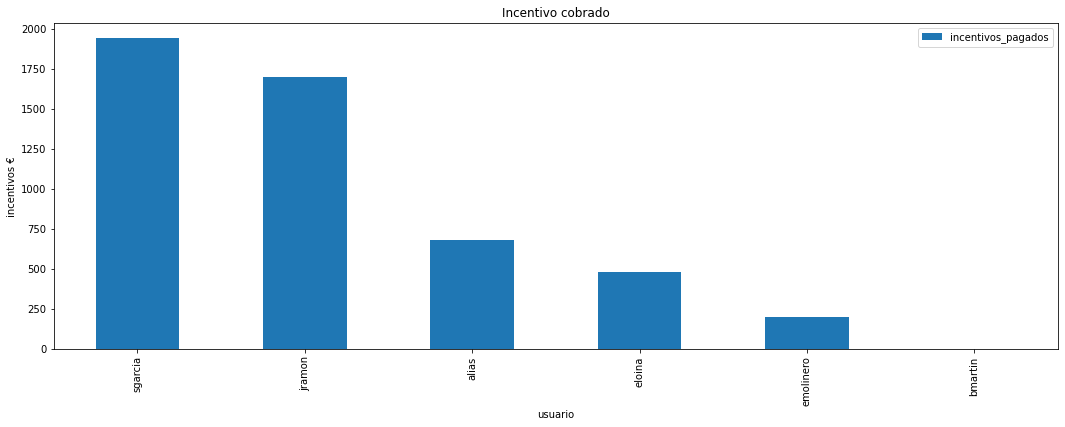

In [15]:
slots.plot(x='usuario',
           y='incentivos_pagados',
        kind='bar',
        stacked=False,
        title='Incentivo cobrado',
        ylabel='incentivos €',
        figsize=(18,6),
        legend=True);



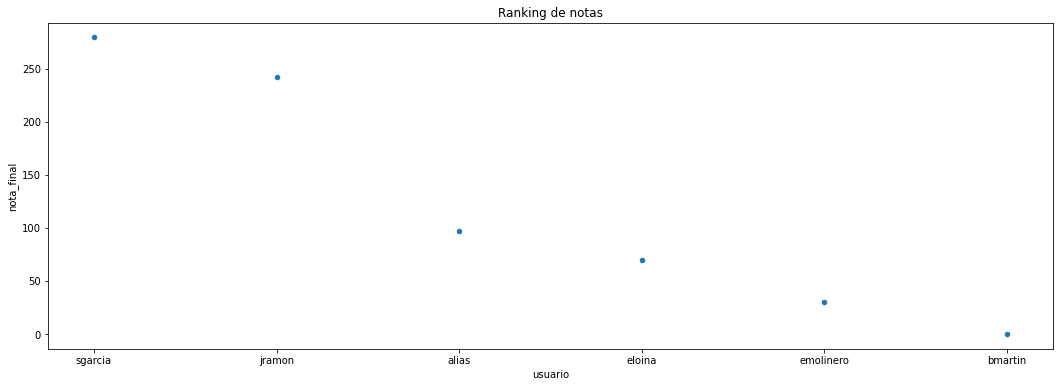

In [16]:
slots.plot(x='usuario',
           y='nota_final',
        kind='scatter',
        stacked=False,
        title='Ranking de notas',
        figsize=(18,6),
        legend=True);


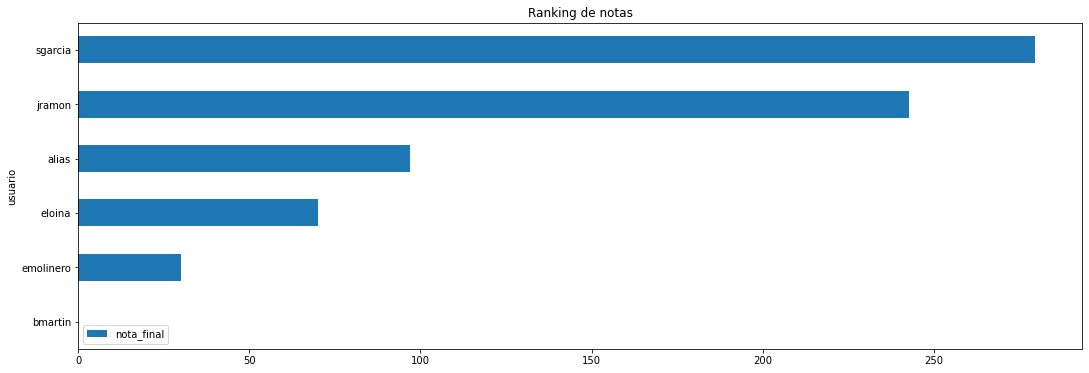

In [17]:
slots.sort_values(by='nota_final').plot(x='usuario',
           y='nota_final',
        kind='barh',
        stacked=False,
        title='Ranking de notas',
        figsize=(18,6),
        legend=True);

### Altair

In [18]:
!pip install altair

In [29]:
!pip install -m http.server


Usage:   
  pip install [options] <requirement specifier> [package-index-options] ...
  pip install [options] -r <requirements file> [package-index-options] ...
  pip install [options] [-e] <vcs project url> ...
  pip install [options] [-e] <local project path> ...
  pip install [options] <archive url/path> ...

no such option: -m


In [30]:
import altair as alt

In [31]:
slots = slots.sort_values(by="incentivos_pagados", ascending=False)
alt.Chart(slots).mark_bar().encode(
    x="usuario:N",
    y="incentivos_pagados"
)


alt.Chart(...)

In [32]:
bars = alt.Chart(slots).mark_bar().encode(
    x="nota_final:Q",
    y="usuario"
)
text = bars.mark_text(
    align='left',
    baseline='middle',
    dx=3  # Nudges text to right so it doesn't appear on top of the bar
).encode(
    text='nota_final:Q'
)
(bars + text).properties(height=200, width=400)

alt.LayerChart(...)

In [33]:
notas=notas.round(1)
notas

,usuario,segmento_maestra,usuario_segmento,tasa_horaria,sum,count,eficacias,horas_trabajadas,factor_corrector,h_trab_seg,cobros_hora,eficacia_hora,suma_notas,max,min,max_seg,min_seg,range_seg,notas_f_corr
0,alias,PREVENTIVO,aliasPREVENTIVO,1.0,0.0,0.0,30.0,150.0,1.0,150.0,0.0,0.2,0.2,100,20,0.2,0.2,0.0,100.0
1,emolinero,BI,emolineroBI,0.6,280.0,3.0,0.0,105.0,0.8,63.0,4.4,0.0,4.4,80,5,11.4,4.4,7.0,5.0
2,emolinero,FECI,emolineroFECI,0.0,120.0,2.0,0.0,105.0,0.8,5.2,22.9,0.0,22.9,90,10,110.5,22.9,87.6,10.0
3,emolinero,ING,emolineroING,0.3,310.0,2.0,0.0,105.0,0.8,31.5,9.8,0.0,9.8,90,10,60.5,9.8,50.6,10.0
4,emolinero,SCF,emolineroSCF,0.0,0.0,0.0,0.0,105.0,0.8,5.2,0.0,0.0,0.0,90,10,89.5,0.0,89.5,10.0
5,jramon,BI,jramonBI,0.6,800.0,2.0,0.0,107.5,0.8,69.9,11.4,0.0,11.4,80,5,11.4,4.4,7.0,80.0
6,jramon,FECI,jramonFECI,0.1,420.0,2.0,0.0,107.5,0.8,10.8,39.1,0.0,39.1,90,10,110.5,22.9,87.6,24.8
7,jramon,ING,jramonING,0.2,1300.0,4.0,0.0,107.5,0.8,21.5,60.5,0.0,60.5,90,10,60.5,9.8,50.6,90.0
8,jramon,SCF,jramonSCF,0.0,370.0,4.0,0.0,107.5,0.8,5.4,68.8,0.0,68.8,90,10,89.5,0.0,89.5,71.5
9,sgarcia,BI,sgarciaBI,0.7,780.0,4.0,0.0,105.0,0.8,73.5,10.6,0.0,10.6,80,5,11.4,4.4,7.0,71.0


In [34]:
alt.Chart(notas).mark_bar().encode(
    x="notas_f_corr:Q",
    y="usuario",
    color="segmento_maestra:N"
).properties(height=200, width=400)

alt.Chart(...)

In [35]:
bars = alt.Chart(notas).mark_bar().encode(
    x=alt.X('notas_f_corr:Q', stack='zero'),
    y=alt.Y('usuario:N'),
    color=alt.Color('segmento_maestra')
)

text = alt.Chart(notas).mark_text(dx=-15, dy=3, color='white').encode(
    x=alt.X('notas_f_corr:Q', stack='zero'),
    y=alt.Y('usuario:N'),
    detail='segmento_maestra:N',
    text=alt.Text('notas_f_corr:Q', format='.1f')
)

(bars + text).properties(height=250, width=1500)

alt.LayerChart(...)

In [36]:
alt.Chart().mark_bar().encode(
    x="notas_f_corr:Q",
    y="usuario",
    color="segmento_maestra:N"
).properties(height=200, width=400)

alt.layer(bars).facet(column=alt.Column('usuario'), data=notas)

alt.FacetChart(...)

In [37]:
alt.Chart(notas).mark_circle(
    filled=True,
    opacity=0.8,
    stroke='black',
    strokeWidth=1
).encode(
    alt.X('segmento_maestra:O', axis=alt.Axis(labelAngle=0)),
    alt.Y('usuario:N'),
    alt.Size('notas_f_corr:Q',
        scale=alt.Scale(range=[0, 1000]),
        legend=alt.Legend(title='size_notas')
    ),
    alt.Color('usuario:N', legend=None),
    tooltip = [alt.Tooltip('segmento_maestra'),
               alt.Tooltip('usuario'),
               alt.Tooltip('notas_f_corr')
              ]
).properties(
    width=450,
    height=320
).interactive()

alt.Chart(...)

In [38]:
selection = alt.selection_multi(fields=['segmento_maestra'], bind='legend')
alt.Chart(notas).mark_circle(
    filled=True,
    opacity=0.8,
    stroke='black',
    strokeWidth=1
).encode(
    alt.X('usuario:O', axis=alt.Axis(labelAngle=0)),
    alt.Y('notas_f_corr:Q'),
    alt.Size('notas_f_corr:Q',
        scale=alt.Scale(range=[0, 1000]),
        legend=alt.Legend(title='tamaño')
    ),
    alt.Color('segmento_maestra:N'),
    tooltip = [alt.Tooltip('segmento_maestra:N'),
               alt.Tooltip('usuario'),
               alt.Tooltip('notas_f_corr')
              ]
).properties(
    width=450,
    height=320
).add_selection(
    selection
)

alt.Chart(...)